<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

In [49]:
#!pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist

import seaborn as sns

from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use("ggplot")

# Clustering with Real Data
Let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [2]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
48849,alexa,pagekit,7,1.0,2.807355,0,5.709609
43082,alexa,videostripe,11,1.0,3.095795,0,19.798570
40000,nivdort,ablewhere,9,1.0,2.641604,0,7.554520
36477,nivdort,milkbegan,9,1.0,3.169925,0,3.838849
12528,gameoverdga,1vejv501iwzk0e1g4mbrv1emjh9g,28,0.0,3.896292,9,0.477121


In [3]:
data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [4]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [5]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [6]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
15683,1.297992,-1.054805,1.690828,0.451007,-0.811719
14155,1.297992,-1.604706,1.276833,1.400399,-0.811719
23017,-0.145884,0.162833,0.157669,-0.498385,-0.680919
1689,2.216822,-1.089174,0.897798,2.919427,-0.722434
15844,1.297992,-1.604706,1.328919,1.400399,-0.811719
25274,0.641685,-0.092478,0.777490,-0.498385,1.045226
1203,2.216822,-1.089174,0.768944,3.109305,-0.624587
29136,0.510423,0.276534,-0.202902,-0.498385,-0.373376
41929,-0.933453,1.144799,-1.265204,-0.498385,0.677445
21567,1.297992,-0.724864,1.414831,0.071251,-0.591634


Finally for convenience, we're going to merge the scaled features with the unscaled features.  

In [7]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [8]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
29671,necurs,qrjvymdwyevpio,14,0.428571,3.521641,0,0.477121,-0.145884,-0.426347,0.497107,-0.498385,-0.722434
26732,necurs,wfeycvhgtdfdy,13,0.692308,3.238901,0,0.602060,-0.277145,0.298797,0.009387,-0.498385,-0.699054
47916,alexa,mp4upload,9,0.666667,2.947703,1,7.539961,-0.802191,0.228297,-0.492925,-0.308506,0.599251
18187,gameoverdga,v7c2z1z2t20o131dhaggkmhuj,25,0.160000,4.023465,9,0.954243,1.297992,-1.164785,1.362745,1.210521,-0.633149
41778,nivdort,thisvoice,9,1.000000,2.947703,0,6.149034,-0.802191,1.144799,-0.492925,-0.498385,0.338964


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [9]:
kmeans = KMeans(n_clusters=2, n_init=2)
    
kmeans.fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[-0.49760996  0.3716326  -0.3885456  -0.4893535   0.20109624]
 [ 1.56899145 -1.17177795  1.22510555  1.5429584  -0.63406745]]
[1 1 1 ... 0 0 0]


In [10]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [11]:
final_data['cluster_id'] = kmeans.labels_

In [12]:
final_data.head()

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
0,bamital,949759d12e0ea541f49675fe4e71a65c,32,0.00000,3.515320,22,0.000000,2.216822,-1.604706,0.486203,3.678940,-0.811719,1
1,bamital,cbaa81d976688b971a43a745795cbb0f,32,0.09375,3.640320,20,0.477121,2.216822,-1.346940,0.701825,3.299183,-0.722434,1
2,bamital,0a175898661ddbad1b3bd99d14d62c6e,32,0.15625,3.593139,19,0.845098,2.216822,-1.175096,0.620440,3.109305,-0.653574,1
3,bamital,c5ee32668c5130c95a9d7eaf91e6b531,32,0.00000,3.694549,20,0.477121,2.216822,-1.604706,0.795370,3.299183,-0.722434,1
4,bamital,b1939fbdf8b57c2683abb9b041aa8518,32,0.18750,3.632049,19,0.903090,2.216822,-1.089174,0.687559,3.109305,-0.642722,1


## Visualize
We can plot the results of our clusters, but only a few features at a time b/c we need each feature to be on an axis. So we can select 2 features at a time to plot and see what the results are and if it looks like the clusters are separated in a clear way. Can I draw a line between them? Is that a requirement?

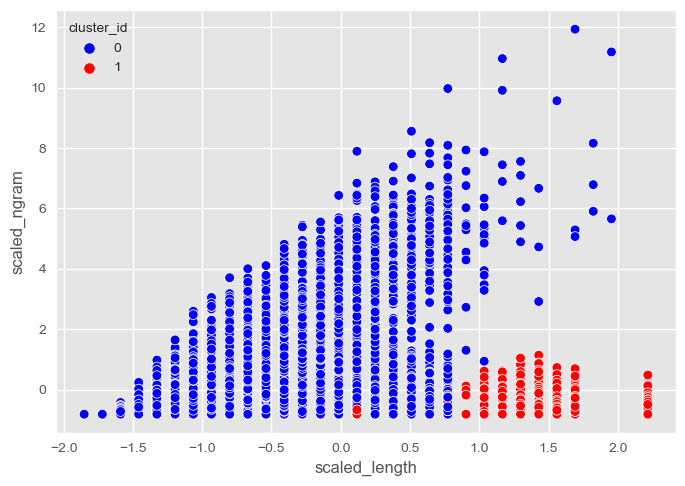

In [13]:
df = pd.DataFrame(np.random.rand(10,2), columns=["A", "B"])
df = final_data.loc[:,['scaled_length','scaled_ngram', 'cluster_id']]
dic = {0:"Blue", 1:"Red"}
sns.scatterplot(x="scaled_length", y="scaled_ngram", data=df, hue="cluster_id", palette = dic);


## Dig in
We can use our dataframe to summarize these results and look at the details of these clusters. 

In [14]:
# count the number of each 'dsrc' found in cluster number 1
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

dsrc
gameoverdga    9993
bamital        2500
necurs          140
alexa             3
Name: count, dtype: int64

In [15]:
final_data[final_data['cluster_id'] == 1]['domain'].sample(15)

20186          ra4dvt3lf62u1bpu48i1h3rrni
14270           k4n0e4z07lz0xkab9d1fjf4ob
15185        1vmiw001xzt1tv1oiw0bn15vv12f
222      929206d69c6413226d2938e027b98413
20382         1anfo2cexpp7x199od4018nw9na
14518          13xvqqcgxktax1p9jkjor27flj
14534         1bwsp0q1m8yr83s5xbjr1y4fgbs
20420         187pohj1r6hg6mb5p8mp1ia9omn
26766               pxtnykkojhpxukggqmrkt
2357     129cda3589419b96d1b19f39f12e97dc
21063           mi1k05qabmv31l37k1d2nscbk
589      4840b0b243e0fc4984d7e1ebbc86dcde
15358            xrbs2drv8jyfvrggfliyf496
16078          ihm8ug18w76i919q0r89chm7mx
870      8a84eb805bc0b7923e4dc09d02accda5
Name: domain, dtype: object

In [16]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(15)

46793              tresellers
40699               milkthrow
7778            vilbwlxsbypqf
30397    gielapllueyajajpixpe
51630                     zju
37286             visitaugust
45436                    tour
2905             krfksxknvekd
34593              spokehouse
23494         jcucuhytttlwtbr
6492           dsvaytwimhimym
32683              threebelow
47567                 podemos
5148          llsebtatyyoufxc
9837            ongrtfldyrvsr
Name: domain, dtype: object

In [17]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

11302     oestyxuipdhjgn
4586       xemdxjxvccesy
4178     iacownwgocnyfij
6764       jrxutxkmvwthd
7964        uatvyawbhcgi
Name: domain, dtype: object

In [18]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

1526    0351d5799825570b097cd83f3eea825a
1947    1b8faefb8c0cdb73bfc8b331fb79d7d5
648     bd7dee8e6d51f3c404b4f0bb55e71e98
1823    7cd3bc98585b7fdc2d8289d35a8d1bd4
48      a8a7966908aebf8ce8894688a6aee5d4
556     46e9527706507c405f2ae020d77acee0
1008    869fc2b1135145f9e5aabf46e0b8373a
1252    dd82f8a0b2b6520e2706f704ba2a289a
1116    556c801d16cc742e9fc2dc96cf6bdac5
441     b93319db244f407199f20ae0dee144b1
Name: domain, dtype: object

In [19]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

35131        humanover
34925         deadelse
38156        spendname
36189         hilllady
38195        wrongname
34658        visithome
34601       watchhouse
39744        trieddont
38342        whichdish
32549    sundaytuesday
Name: domain, dtype: object

In [20]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

22546    kujnifxvqwkpyytegqohv
22632     xwhqnkkesylwbydfnsxm
22711       wuiioaeyklhgcxwmad
22736       efkwmijhtpxsgrhfgq
22743      shngncqtfjlfhdjrtks
                 ...          
31897    pyskufklybvjhfpywtvlc
31956      ixhlkocwfwwdktjmdvj
32246     sxgkkqnnfjsoyhebpypw
32434    cqvkgxsntoevqbkxnyvyf
32456    qxvbbtlxhwguongdywukl
Name: domain, Length: 140, dtype: object

In [21]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
8454,cryptolocker,ssjypmkpnxpmxt,14,0.428571,3.039149,0,0.000000,-0.145884,-0.426347,-0.335183,-0.498385,-0.811719,0
35179,nivdort,deadover,8,1.000000,2.500000,0,9.031937,-0.933453,1.144799,-1.265204,-0.498385,0.878448,0
25642,necurs,bwsftmuwicdpxrvgjcn,19,0.210526,4.037401,0,1.301030,0.510423,-1.025863,1.386784,-0.498385,-0.568254,1
22623,necurs,wekfjrnp,8,0.000000,3.000000,0,0.000000,-0.933453,-1.604706,-0.402714,-0.498385,-0.811719,0
25899,necurs,emppanmvootfi,13,0.923077,3.238901,0,5.434824,-0.277145,0.933298,0.009387,-0.498385,0.205312,0


## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method: 
1. Calc k-means clustering on the dataset for a range of values for k (say from 1-10).
2. For each value of k, compute Sum of squared distances of samples to their closest cluster center. Often called the Within-Cluster Sum of Squares.
3. Plot these values for each k
4. Determine best value of k based on inflection point (elbow) in the graph.
   
If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. 


### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score. That is, do you see an elbow in this graph? That should be the 'ideal' number of clusters for our k-means model of this data. 

Try different numbers for the sample and see how this affects the graph. 
Try differen values for the range of k to see how this changes the inflection point

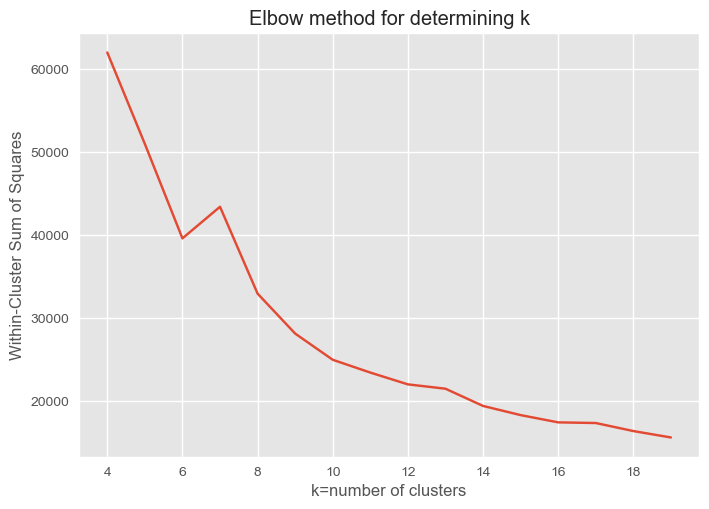

In [22]:
WCSS=[]
for i in range(4,20):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(final_data[scaled_feature_columns].sample(50000))
  WCSS.append(kmeans.inertia_)
WCSS

plt.plot(range(4,20),WCSS);
plt.ylabel('Within-Cluster Sum of Squares')
plt.xlabel('k=number of clusters')
plt.title('Elbow method for determining k');

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

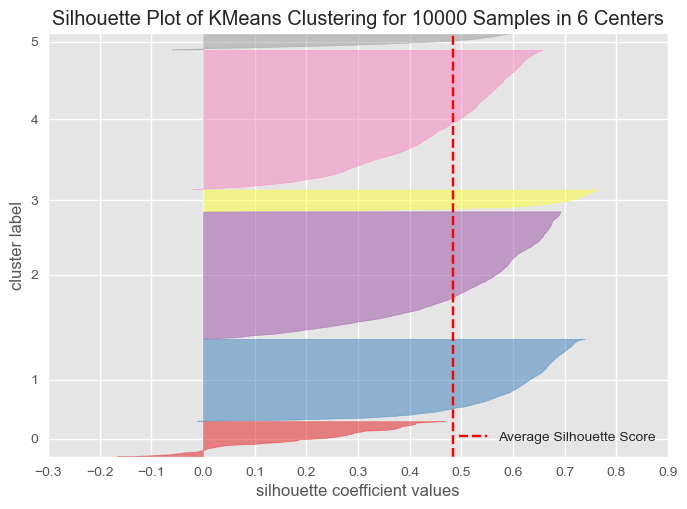

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:
visualizer = SilhouetteVisualizer( KMeans(n_clusters=6, n_init=3))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Anomaly Detection using Clustering methods
Let's use a hierarchical clustering method to detect anomalies in a set of data points. The one we will use is called [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). 

First we will create an anomaly dataset that only has 20 DGA rows and 1000 legit samples. Thus, there are 20 anomalies in this dataset that we know of. Then we will see if our clustering method can detect them. 

In [24]:
dga_data = pd.read_csv('../data/dga_features_final_df_domain.csv')
print(dga_data.isDGA.value_counts())

isDGA
dga      1000
legit    1000
Name: count, dtype: int64


In [25]:
is_dga = dga_data[dga_data['isDGA']=='dga'].sample(20)
not_dga = dga_data[dga_data['isDGA']=='legit']

In [26]:
print(len(is_dga))
print(len(not_dga))

20
1000


In [27]:
dga_anomaly_data = pd.concat([is_dga, not_dga])
dga_anomaly_data['isDGA'].value_counts()

isDGA
legit    1000
dga        20
Name: count, dtype: int64

In [28]:
dga_anomaly_data_domain = dga_anomaly_data
dga_anomaly_data = dga_anomaly_data.drop('domain',axis=1)

#### Now use this dataset that conatins only a few anomalies in clustering

First we want to scale the data because it is clustering which means that distance is important and that is extremely sensitive to different scales. The code is below, but if you want you can try to use  the Min Max Scaler after you fir the model to see if it changes the resuls. 

In [29]:
dga_anomaly_data.head()

,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
1,dga,26,10,4.132944,0.333333,1,715.217265
649,dga,15,0,3.373557,0.250000,0,943.115751
356,dga,24,6,3.772055,0.200000,3,444.999671
739,dga,9,0,2.725481,0.000000,0,573.542989
712,dga,9,0,2.725481,0.500000,0,1582.544312


In [30]:
dga_anomaly_data  = StandardScaler().fit_transform(dga_anomaly_data.loc[:,'ngrams'].values.reshape(-1, 1))

Now that we have prepared the data, we can put it into a model. Call the Agglomerative Clustering model from sklearn and fit it to the data. name the model **agglomerative_clust**

In [31]:
agglomerative_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Your code here
agglomerative_clust = agglomerative_clust.fit(dga_anomaly_data)

# pull out the label of the cluster each point belongs to. 
labels_for_clusters = agglomerative_clust.labels_

This plot_dendrogram function will plot the dendrogram for the cluster model you just fitted to the data. 

In [32]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Use the plot_dendrogram function to plot the dendrogram. You an get lower and lower levels if you increase the value of **p**. Try plotting a few values of **p** to see the difference and notice what happens.

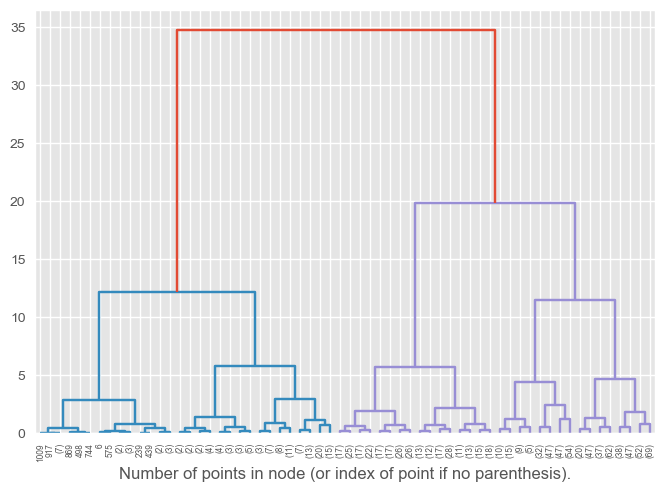

In [33]:
plot_dendrogram(agglomerative_clust, truncate_mode="level", p=5);
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Notice that in the plot there are some digits on the x-axis with no parenthesis. These are nodes that did not have more than 1 data point. We want to take a look at these because they are 'far' enough away from the rest of the data to warrant their own node, and thus could be an anomaly. 

Below, use the original pandas data frame to print the rows of the single nodes and see if these are our few DGAs. 

In [34]:
dga_anomaly_data_domain.iloc[0,:]

isDGA                                     dga
domain             72j5rn1l9mzleo6203v1ogenfl
length                                     26
digits                                     10
entropy                              4.132944
vowel-cons                           0.333333
firstDigitIndex                             1
ngrams                             715.217265
Name: 1, dtype: object

In [35]:
dga_anomaly_data_domain.iloc[3,:]

isDGA                     dga
domain              jsckhhcqx
length                      9
digits                      0
entropy              2.725481
vowel-cons                0.0
firstDigitIndex             0
ngrams             573.542989
Name: 739, dtype: object

In [36]:
dga_anomaly_data_domain.iloc[5,:]

isDGA                                           dga
domain             71af3f42ab8f85a67ee1b2cfaeafd912
length                                           32
digits                                           15
entropy                                    3.641127
vowel-cons                                 0.888889
firstDigitIndex                                   1
ngrams                                   656.859633
Name: 145, dtype: object

In [37]:
dga_anomaly_data_domain.iloc[29,:]

isDGA                    legit
domain               recreativ
length                       9
digits                       0
entropy               2.725481
vowel-cons                 0.8
firstDigitIndex              0
ngrams             1878.208995
Name: 1009, dtype: object

Another thing to note is just to look at the contents of the smallest cluster (depending on how small you think your anomalies are. IN this case our smallest cluster contains the DGAs. Thus, our model accurately pulled out the DGAs into their own 'anomaly' cluster. 

## DBSCAN
Another clustering method we can try is DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [38]:
dbscan = DBSCAN(min_samples=50)

In [39]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [40]:
final_data['dbs_default'].value_counts()

dbs_default
 1    39301
 2     9973
 0     2500
-1      284
 4      259
 3      116
 5       45
Name: count, dtype: int64

In [41]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

dsrc
cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: count, dtype: int64

In [42]:
final_data[final_data['dbs_default'] == 1 ][['dsrc','domain']].sample(10)

,dsrc,domain
6942,cryptolocker,qerrlxwqverl
38091,nivdort,wenthigh
36961,nivdort,felthope
44850,alexa,bunnings
43892,alexa,designboom
6188,cryptolocker,spsaoxwfbcpspnh
9735,cryptolocker,wafgmoqpmnun
44972,alexa,ahcaijing
47016,alexa,dxomark
35462,nivdort,dutybody


In [43]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

15666    gameoverdga
49175          alexa
47099          alexa
47438          alexa
47547          alexa
47813          alexa
49102          alexa
46128          alexa
52372          alexa
45260          alexa
Name: dsrc, dtype: object

In [44]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

36288     triedjuly
34776     offerback
40679    sundaytree
41824     groupdont
38305     spokegrow
Name: domain, dtype: object

In [45]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

dsrc
gameoverdga    9973
Name: count, dtype: int64

In [46]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

dsrc
cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: count, dtype: int64

In [47]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

5010        mwmvdjvdvpjg
5171     mfgslvaxxkxcqgo
10694       vomjbmalrrqb
8370      lmisgqiyvgghnb
9338      hqorfucxsqmlug
9390      cfbgferekcpdoq
6957        dmxmlhxmrcpl
3611       rxhyqwwcsybse
6684       ciwysqctoaskp
6265     vwwjjcdmyaqgvbr
Name: domain, dtype: object

In [48]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

28661    pdyvstemniryoslxtisuy
32483    blkpqpydphadyxfqmwjuc
31169          oshkunnxdlgicds
28047          glqudwnerygdola
25384       qsaijgrrrfctqdmhxf
28906                  wveitnb
24239           fjcobdfwulhxbq
27417                tabaxmsiy
30470                djtktsjvr
28280          ymdpfeivbklwpki
Name: domain, dtype: object